# Bibliotecas utilizadas

In [1]:
import datetime as dt
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas_datareader import data as web

# Definição dos ativos e do período de análise

In [2]:
#-- Serão consideradas as cotações históricas do ano de 2021
inicial = '01/01/2021'
final = '31/12/2021'

data_inicial = dt.datetime.strptime(inicial,'%d/%m/%Y')
data_final = dt.datetime.strptime(final,'%d/%m/%Y')

#-- Os ativos foram escolhidos de forma aleatória, a partir da composição do índice IBOV
lista_ativos = ['PETR4', 'JBSS3', 'SUZB3', 'B3SA3']

ativos = [n + '.SA' for n in lista_ativos]

# Obtenção do valor da taxa SELIC

In [3]:
#-- Será considerada a taxa SELIC vigente no último período de 2021

url = f'http://api.bcb.gov.br/dados/serie/bcdata.sgs.432/dados?formato=json&dataInicial={inicial}&dataFinal={final}'

taxa_selic_mensal = pd.read_json(url)

selic = taxa_selic_mensal.iloc[-1]['valor']/100

selic

0.0925

# Cotações históricas dos ativos

In [4]:
#--  As informações das cotações históricas serão obtidas no site Yahoo Finance

cotacoes = web.DataReader(ativos, 'yahoo', data_inicial, data_final)
cotacoes = cotacoes['Close']
hist = cotacoes.pct_change()
hist = hist.replace(np.nan, 0)
hist.head()

Symbols,PETR4.SA,JBSS3.SA,SUZB3.SA,B3SA3.SA
Date,,,,
2021-01-04,0.000000,0.000000,0.000000,0.000000
2021-01-05,0.039087,0.014524,-0.004583,0.001968
2021-01-06,0.001997,-0.008842,-0.018247,-0.016367
2021-01-07,0.029900,0.012319,0.085461,0.027953
2021-01-08,0.003871,0.023919,0.004641,0.014730


# Análise gráfica das cotações

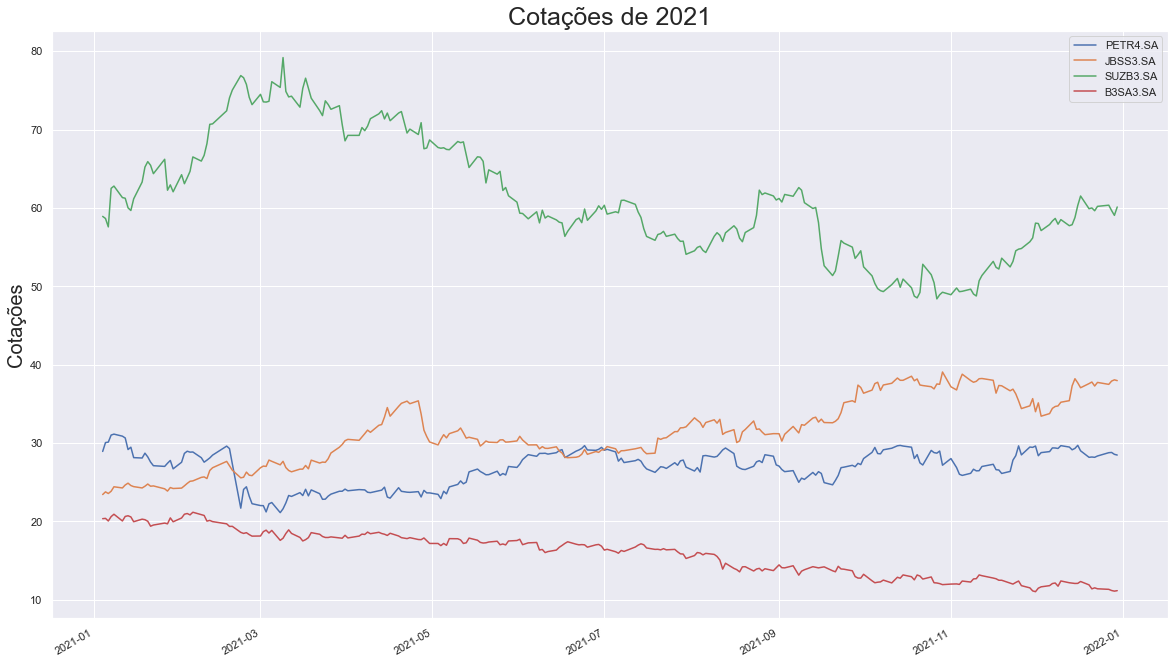

In [5]:
#-- Serão plotados os valores históricos dos ativos

sns.set(rc = {'figure.figsize':(20,12)})

cotacoes.plot()
plt.title('Cotações de 2021', size = 25)
plt.xlabel('')
plt.ylabel('Cotações', size = 20)
plt.legend(loc = "upper right")

# Retorno esperado e risco

In [6]:
#-- O retorno esperado de um ativo é a média das variações
#-- O risco de um ativo é o desvio-padrão da série
#-- Para transformar o retorno esperado diário em anual serão considerados 252 dias úteis

dict_ativos = {}

for ativo in ativos:
    retorno_esperado = hist[ativo].mean()
    risco = hist[ativo].std()
    
    dict_ativos[ativo] = {}
    dict_ativos[ativo]['Retorno Esperado Diário'] = retorno_esperado
    dict_ativos[ativo]['Risco'] = risco
    
variaveis = pd.DataFrame.from_dict(dict_ativos, orient = 'index')
variaveis['Retorno Esperado Anual'] = (variaveis['Retorno Esperado Diário'] + 1) ** 252 - 1
variaveis

,Retorno Esperado Diário,Risco,Retorno Esperado Anual
PETR4.SA,0.000330,0.027699,0.086706
JBSS3.SA,0.002154,0.019856,0.719938
SUZB3.SA,0.000291,0.020529,0.076007
B3SA3.SA,-0.002163,0.023175,-0.420505


# Matrizes de covariância e correlação

In [7]:
#-- A covariância é uma medida do grau de dependência entre duas variáveis
#-- A covariância será multiplicada por 252 devido ao número de dias úteis no ano

covariancia = hist.cov()*252
covariancia

Symbols,PETR4.SA,JBSS3.SA,SUZB3.SA,B3SA3.SA
Symbols,,,,
PETR4.SA,0.193343,0.025757,0.001989,0.045405
JBSS3.SA,0.025757,0.099352,0.013159,0.022410
SUZB3.SA,0.001989,0.013159,0.106205,0.008750
B3SA3.SA,0.045405,0.022410,0.008750,0.135345


In [8]:
#-- A correlação é uma normalização da covariância
#-- A correlação varia entre -1 (quando uma sobe a outra desce) e 1 (quando uma sobe a outra também sobe)
#-- Para a composição das carteiras buscamos correlações baixas, perto de 0

hist.corr()

Symbols,PETR4.SA,JBSS3.SA,SUZB3.SA,B3SA3.SA
Symbols,,,,
PETR4.SA,1.000000,0.185845,0.013879,0.280683
JBSS3.SA,0.185845,1.000000,0.128100,0.193258
SUZB3.SA,0.013879,0.128100,1.000000,0.072979
B3SA3.SA,0.280683,0.193258,0.072979,1.000000


# Montagem de carteiras através do Método de Monte-Carlo

In [9]:
#-- Será gerado um número muito grande de carteiras aleatórias
#-- Serão plotados os pares Retorno e Risco das carteiras
#-- Será calculado o Índice de Sharpe pra cada carteira, utilizando o valor da SELIC encontrado acima

n_carteiras = 1000000

dict_carteiras = {}

np.random.seed(100)

for n in range(n_carteiras):
    
    #-- Definição das participações de cada ativo da carteira de forma aleatória
    pesos = np.random.random_sample(len(lista_ativos))
    pesos = np.round(pesos / sum(pesos), 4)
    
    #-- Retorno e risco da carteira
    retorno_carteira = 0
    risco_carteira = 0
   
    for i in range(len(lista_ativos)):
        retorno_carteira += pesos[i] * variaveis.iloc[i]['Retorno Esperado Anual']
        
        for j in range(len(lista_ativos)):
            risco_carteira += pesos[i] * pesos[j] * covariancia.iloc[i][j]
    
    dict_carteiras['Carteira '+ str(n+1)] = {}
    dict_carteiras['Carteira '+ str(n+1)]['Retorno'] = retorno_carteira
    dict_carteiras['Carteira '+ str(n+1)]['Risco'] = risco_carteira ** 0.5
    dict_carteiras['Carteira '+ str(n+1)]['Sharpe'] = (retorno_carteira - selic) / risco_carteira ** 0.5

carteiras = pd.DataFrame.from_dict(dict_carteiras, orient='index')
carteiras.tail()

,Retorno,Risco,Sharpe
Carteira 999996,0.242294,0.221820,0.675298
Carteira 999997,0.103650,0.236797,0.047087
Carteira 999998,0.292504,0.228350,0.875864
Carteira 999999,-0.042359,0.235689,-0.572190
Carteira 1000000,0.283458,0.213370,0.894961


# Dispersão das carteiras

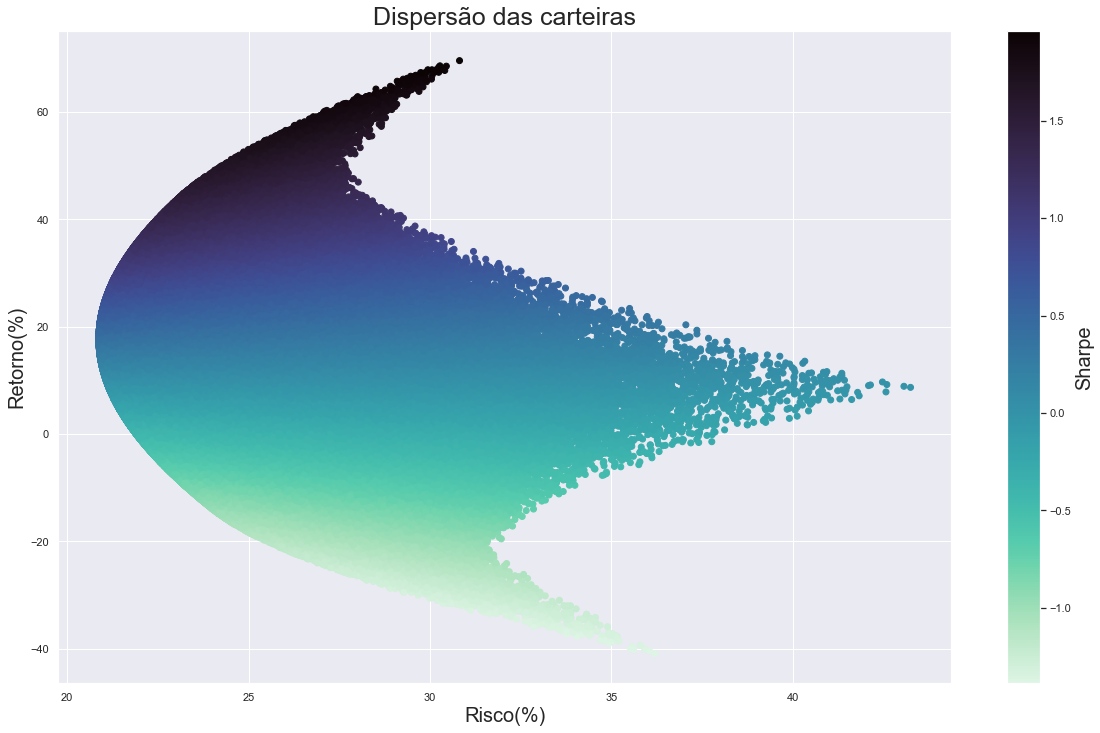

In [10]:
sns.set(rc = {'figure.figsize':(20,12)})

colorbar, ax = plt.subplots()
points = ax.scatter(x = carteiras['Risco'] * 100, y = carteiras['Retorno'] * 100, 
                    c = carteiras['Sharpe'], cmap='mako_r')
plt.title('Dispersão das carteiras', size = 25)
plt.xlabel('Risco(%)', size = 20)
plt.ylabel('Retorno(%)', size = 20)
colorbar.colorbar(points).set_label(label = 'Sharpe',size=20)

# Definição da Fronteira Eficiente

In [11]:
#-- A Fronteira Eficiente é composta das carteiras de maior retorno, para um determinado nível de risco

intervalo = (carteiras.loc[carteiras['Retorno'].idxmax()]['Risco'] - carteiras['Risco'].min()) / 10000

limite_inferior = carteiras['Risco'].min()
limite_superior = limite_inferior + intervalo

lista_eficientes = []

retorno_maximo = 0 

while limite_inferior < carteiras.loc[carteiras['Retorno'].idxmax()]['Risco']:
    df = carteiras[(carteiras['Risco'] >= limite_inferior) & (carteiras['Risco'] <= limite_superior)]
    
    if not df.empty:
        retorno_max = df['Retorno'].max()
        if retorno_max > retorno_maximo:
            retorno_maximo = retorno_max
            maximo = df['Retorno'].idxmax()
            lista_eficientes.append(maximo)
    
    limite_inferior += intervalo
    limite_superior += intervalo
    
carteiras_eficientes = carteiras.loc[lista_eficientes]
carteiras_eficientes.head()

,Retorno,Risco,Sharpe
Carteira 106393,0.184248,0.208762,0.439485
Carteira 288169,0.185581,0.208771,0.445852
Carteira 66213,0.186907,0.208782,0.452181
Carteira 31055,0.188459,0.208795,0.459586
Carteira 587298,0.188996,0.208814,0.462114


# Fronteira Eficiente

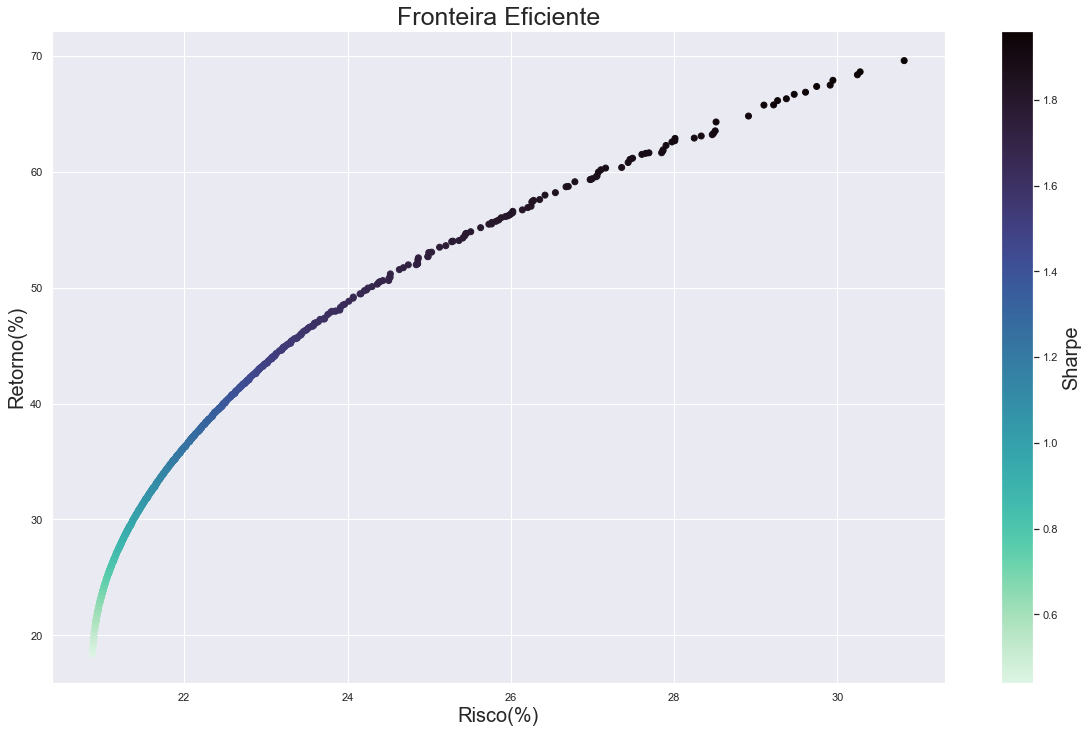

In [12]:
sns.set(rc = {'figure.figsize':(20,12)})

colorbar, ax = plt.subplots()
points = ax.scatter(x = carteiras_eficientes['Risco'] * 100, y = carteiras_eficientes['Retorno'] * 100, 
                    c = carteiras_eficientes['Sharpe'], cmap='mako_r')
plt.title('Fronteira Eficiente', size = 25)
plt.xlabel('Risco(%)', size = 20)
plt.ylabel('Retorno(%)', size = 20)
colorbar.colorbar(points).set_label(label = 'Sharpe',size=20)